# Challenge Technique : Nettoyage et Normalisation des Adresses

## Contexte

Dans le cadre de la poursuite de ma candidature et pour répondre à un défi pratique posé par la startup **Longue vie aux objets**, ce notebook se concentre sur le nettoyage et la normalisation d'un jeu de données d'adresses. L'objectif principal est de garantir que les adresses sont conformes au standard de la Base d'Adresse Nationale (BAN) et de corriger les coordonnées géographiques (latitude et longitude) pour une précision accrue.

## Objectifs

1. **Normalisation des Adresses** :
   - Transformer et nettoyer les données d'adresse pour qu'elles correspondent aux standards de la BAN.
   - Assurer la cohérence de la casse et du formatage au sein du jeu de données.


| Nom               | Description                                             |
|-------------------|---------------------------------------------------------|
| type              | type de résultat trouvé : rue, numéro de plaque, lieu-dit, commune |
| numéro de plaque  | numéro avec indice de répétition éventuel (bis, ter, A, B) |
| nom               | numéro éventuel et nom de voie ou lieu dit               |
| code postal       | code postal                                             |
| code de ville     | code INSEE de la commune                                |
| commune           | nom de la commune                                      |
| arrondissement    | nom de l’arrondissement (Paris/Lyon/Marseille)          |
| context           | n° de département, nom de département et de région      |


2. **Correction de la Géolocalisation** :
   - Vérifier et corriger les valeurs de latitude et longitude.
   - Assurer que les coordonnées géographiques sont précises et fiables.
  


## Etape n°0

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import math
from IPython.display import display, HTML

# Load data from CSV
df = pd.read_csv("POI sample addresses and locations.csv")

# Constants
ROWS_COUNT = len(df)
REGEX_NON_ALPHABETIC = '^[^a-zA-Z]+$'
API_BAN_URL = 'https://api-adresse.data.gouv.fr/search/csv/'

In [2]:
def display_dataframe(dataframe):
    """
    Display a pandas DataFrame as HTML in Jupyter Notebook.
    
    :param dataframe: pandas DataFrame to display
    """
    display(HTML(dataframe.to_html()))


def plot_histogram(data, bins=60, n=10, title="Cumulative Histogram", xlabel="Value", ylabel="Cumulative Sum"):
    """
    Plot a histogram and cumulative histogram of the provided data, including decatiles.
    
    :param data: Data to be plotted
    :param bins: Number of bins for the histogram
    :param n: Number of decatiles to display
    """
    # Plotting the histogram
    plt.hist(data, bins=bins, color='red', alpha=1)
    
    # Plotting the cumulative histogram
    plt.hist(data, bins=bins, cumulative=True, color='blue', alpha=0.3)
    
    # Calculating mean, median, quartiles, and decatiles
    mean = data.mean()
    median = data.median()
    quartiles = [data.quantile(0.25), data.quantile(0.75)]
    decatiles = [data.quantile(i/n) for i in range(1, n)]
    
    # Adding vertical lines for mean, median, quartiles, and decatiles
    plt.axvline(mean, color='red', linestyle='dashed', linewidth=2)
    plt.axvline(median, color='green', linestyle='dashed', linewidth=2)
    for q in quartiles:
        plt.axvline(q, color='orange', linestyle='dashed', linewidth=2)
    for d in decatiles:
        plt.axvline(d, color='purple', linestyle='dashed', linewidth=1)

    # Adding annotations for mean, median, quartiles, and decatiles
    plt.text(mean, plt.ylim()[1]*0.9, 'Mean', color='red', horizontalalignment='right')
    plt.text(median, plt.ylim()[1]*0.85, 'Median (Q2)', color='green', horizontalalignment='right')
    plt.text(quartiles[0], plt.ylim()[1]*0.8, 'Q1', color='orange', horizontalalignment='right')
    plt.text(quartiles[1], plt.ylim()[1]*0.75, 'Q3', color='orange', horizontalalignment='right')
    for i, d in enumerate(decatiles):
        plt.text(d, plt.ylim()[1]*(0.7-0.05*i), f'D{i+1}', color='purple', horizontalalignment='right')
    
    # Setting title and labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # Displaying the plot
    plt.show()


def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points on the Earth's surface.

    Uses the Haversine formula to compute the distance based on latitude and
    longitude coordinates, which are passed as parameters. This formula accounts
    for the curvature of the Earth.

    Parameters:
    lat1 (float): Latitude of the first point in decimal degrees.
    lon1 (float): Longitude of the first point in decimal degrees.
    lat2 (float): Latitude of the second point in decimal degrees.
    lon2 (float): Longitude of the second point in decimal degrees.

    Returns:
    float: Distance between the two points in meters.
    """

    # Radius of the Earth in meters
    R = 6371000

    # Convert latitude and longitude from degrees to radians
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    # Haversine formula
    a = math.sin(delta_phi / 2)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Distance in meters
    distance = R * c
    return distance


def calculate_deciles(series, n):
    """
    Calculate and return the quantiles for a specified pandas Series.

    :param series: pandas Series
    :param n: number of equal parts to divide the data into
    :return: dictionary containing the quantiles
    """
    quantiles = {f"Quantile {i}/{n}": series.quantile(i/n) for i in range(1, n + 1)}
    return quantiles


def rate_of_nan(current_dataframe):
    """
    Calculate the percentage of NaN values in each column of the DataFrame.

    :param current_dataframe: pandas DataFrame
    :return: pandas Series with the percentage of NaN values for each column
    """
    rows_count = len(current_dataframe)
    return 100 * current_dataframe.isna().sum() / rows_count

def request_api_adresse(input_file='previous_dataframe_01.csv', output_file='after_dataframe_01.csv', column="completed_address"):
    """
    Sends a CSV file to the French Government's Address API for geocoding and writes the API response to an output file.

    :param input_file: Name of the input CSV file containing address data.
    :param output_file: Name of the output CSV file to store the API response.
    """
    
    # Open the input file using a context manager
    with open(input_file, 'rb') as file:
        files = {
            'data': (input_file, file),
            'columns': ('', column)
        }

        # Perform the POST request
        response = requests.post(API_BAN_URL, files=files)

    # Check if the request was successful
    if response.status_code == 200:
        # Write the response content to an output file
        with open(output_file, 'wb') as file:
            file.write(response.content)
    else:
        print(f"Error during the request: Status Code {response.status_code}")

**Fonctions de comparaison des dataframes**

In [3]:
results_columns = [
    "result_type",
    "result_housenumber",
    "result_street",
    "result_postcode",
    "result_citycode",
    "result_city",
    "result_district",
    "result_context",
    "result_score",
    "latitude",
    "longitude",
    "origin"
]

def generate_result_row(x, suffix):
    """
    Generate a dictionary of results for a given row and suffix.

    Args:
    x (pd.Series): A row from a pandas DataFrame.
    suffix (str): A suffix indicating which set of results to use ('_a' or '_b').

    Returns:
    dict: A dictionary with selected results.
    """
    result_row = {"identifiant_unique": x["identifiant_unique"]}
    for col in results_columns:
        result_row[col] = x[f"{col}{suffix}"]
    return result_row


def select_rows(x):
    """
    Select the best row based on the result score.

    Args:
    x (pd.Series): A row from a pandas DataFrame.

    Returns:
    dict: A dictionary with the best results for the row.
    """
    if np.isnan(x["result_score_a"]):
        return generate_result_row(x, suffix="_b")
    elif np.isnan(x["result_score_b"]) or x["result_score_a"] >= x["result_score_b"]:
        return generate_result_row(x, suffix="_a")
    else:
        return generate_result_row(x, suffix="_b")


def select_best_rows(df_a, df_b):
    """
    Select the best rows from two DataFrames based on result scores.

    Args:
    df_a (pd.DataFrame): The first DataFrame.
    df_b (pd.DataFrame): The second DataFrame.

    Returns:
    pd.DataFrame: A DataFrame with the best rows from both df_a and df_b.
    """
    merged_df = pd.merge(df_a, df_b, on='identifiant_unique', how='outer', suffixes=('_a', '_b'))
    best_rows = merged_df.apply(select_rows, axis=1)
    return pd.DataFrame(best_rows.tolist())


In [4]:
# Displaying the first 5 rows of the DataFrame
df.head(5)

,identifiant_unique,adresse,adresse_complement,code_postal,ville,st_x,st_y
0,lescreadevicky_203741_reparation_0633175984,3 IMPASSE DES TUILIERS,NaN,71210.0,MONTCHANIN,4.469140,46.758914
1,bijouterie_obrecht_93995_reparation,24 RUE DE LA GARE,NaN,68690.0,MOOSCH,7.051734,47.861574
2,amberley_design_services_172205_reparation_054...,4 LA TAILLEZERIE,NaN,17150.0,BOISREDON,-0.535589,45.330314
3,bijoux_enora_19597_reparation_0669640932,2 CHEMIN DES VIRGILES,LE CAPET D AZUR BAT H23,83120.0,SAINTE MAXIME,6.628063,43.313087
4,simonet_lionel_213050_reparation_0680960766,66 RUE DU PARC,NaN,77360.0,VAIRES SUR MARNE,2.638240,48.866954


**Conservation des lignes ayant des villes, codes postaux et adresses**

In [5]:
df = df[df.ville.notna() & df.code_postal.notna() & df.adresse.notna()]

# Print the rate of NaN values in each column of the filtered DataFrame
print(rate_of_nan(df))

identifiant_unique     0.000000
adresse                0.000000
adresse_complement    83.908277
code_postal            0.000000
ville                  0.000000
st_x                   0.120688
st_y                   0.120688
dtype: float64


**Les codes postaux sont castés en integer**

In [6]:
# Convert 'code_postal' to integers, handling potential errors
try:
    df.code_postal = df.code_postal.astype(pd.Int64Dtype())
except ValueError as e:
    print(f"Error converting 'code_postal' to int: {e}")

# Convert 'ville' to strings
df["ville"] = df.ville.astype(str)

**Preprocessing des compléments d'adresses**

In [7]:
# Conditions for matching 'adresse_complement' with other columns
condition_adresse_complement_adresse = df.adresse_complement == df.adresse
condition_adresse_complement_ville = df.adresse_complement == df.ville
condition_adresse_complement_code_postal = df.adresse_complement.astype(str) == df.code_postal.astype(str)

# Printing the number of rows where conditions are true
print(f"Nombre de lignes où adresse_complement est égal à adresse: {len(df[condition_adresse_complement_adresse])}")
print(f"Nombre de lignes où adresse_complement est égal à ville: {len(df[condition_adresse_complement_ville])}")
print(f"Nombre de lignes où adresse_complement est égal à code_postal: {len(df[condition_adresse_complement_code_postal])}")

# Cleaning 'adresse_complement' by setting it to an empty string where conditions are met
df.loc[condition_adresse_complement_adresse | condition_adresse_complement_ville | condition_adresse_complement_code_postal, 'adresse_complement'] = ""

Nombre de lignes où adresse_complement est égal à adresse: 72
Nombre de lignes où adresse_complement est égal à ville: 24
Nombre de lignes où adresse_complement est égal à code_postal: 1


**Preprocessing des adresses**

In [8]:
# Condition to check if 'adresse' and 'ville' columns have the same values
condition_adresse_ville = df.adresse == df.ville

# Condition to check if 'adresse' and 'code_postal' columns have the same values
condition_adresse_code_postal = df.adresse == df.code_postal

# Condition to check if 'adresse' column contains non-alphabetic characters only
condition_adresse_not_alphabetic = df.adresse.str.contains(REGEX_NON_ALPHABETIC, regex=True)

# Filtering out rows where 'adresse' matches either 'ville' or 'code_postal'
df = df[(condition_adresse_ville == False) & (condition_adresse_code_postal == False)]

# Converting all city names in the 'ville' column to uppercase
df["ville"] = df["ville"].apply(lambda x: x.upper())

In [9]:
# Swapping values between 'adresse' and 'adresse_complement' under specific conditions

# Store 'adresse' values in a temporary variable where 'adresse' has no alphabetic characters and 'adresse_complement' is not null
temp = df.loc[condition_adresse_not_alphabetic & df.adresse_complement.notna(), 'adresse']

# Swap 'adresse' with 'adresse_complement'
df.loc[condition_adresse_not_alphabetic & df.adresse_complement.notna(), 'adresse'] = df.loc[condition_adresse_not_alphabetic & df.adresse_complement.notna(), 'adresse_complement']

# Replace 'adresse_complement' with original 'adresse' values from temp
df.loc[condition_adresse_not_alphabetic & df.adresse_complement.notna(), 'adresse_complement'] = temp

# Keep rows where 'adresse' contains alphabetic characters OR 'adresse_complement' is not null
df = df[(condition_adresse_not_alphabetic == False) | df.adresse_complement.notna()]

df.loc[df.adresse_complement.isna(), "adresse_complement"] = ""

/var/folders/0q/hfx4v2917ns4l4_yd5c0ydbw0000gn/T/ipykernel_13893/683193739.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[(condition_adresse_not_alphabetic == False) | df.adresse_complement.notna()]


**Preprocessing codes postals, villes**

In [10]:
# Load the CSV file into a DataFrame
postal_code_df = pd.read_csv("code_postals.csv", sep=";")

# Remove the "Ligne_5" column
if "Ligne_5" in postal_code_df.columns:
    del postal_code_df["Ligne_5"]

# Sort the DataFrame by "Code_postal"
postal_code_df_sorted = postal_code_df.sort_values(["Code_postal"])

# Check if 'code_postal' in df exists in the 'Code_postal' column of postal_code_df
included_postal_code = df['code_postal'].isin(postal_code_df["Code_postal"])

step_0_results_df = df[included_postal_code]

# Format 'code_postal'
step_0_results_df['code_postal'] = df['code_postal'].apply(lambda x: f"{x:05d}")

/var/folders/0q/hfx4v2917ns4l4_yd5c0ydbw0000gn/T/ipykernel_13893/3315411494.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  step_0_results_df['code_postal'] = df['code_postal'].apply(lambda x: f"{x:05d}")


**sauvegarder le resultat de l'etape 0**

In [11]:
step_0_results_df.to_csv("step_0_results.csv")

## Etape n°1

Cette etape est le cas d'usage le plus simple.

**concatenation des données**

In [12]:
step_1_df = step_0_results_df[["identifiant_unique"]]
step_1_df["completed_address"] = step_0_results_df["adresse_complement"] + " " + step_0_results_df["adresse"] + " " + step_0_results_df["code_postal"] + " " + step_0_results_df["ville"]

/var/folders/0q/hfx4v2917ns4l4_yd5c0ydbw0000gn/T/ipykernel_13893/588806274.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  step_1_df["completed_address"] = step_0_results_df["adresse_complement"] + " " + step_0_results_df["adresse"] + " " + step_0_results_df["code_postal"] + " " + step_0_results_df["ville"]


In [13]:
step_1_df.to_csv("step_1_inputs.csv")
request_api_adresse(input_file='step_1_inputs.csv', output_file='step_1_results.csv', column="completed_address")
step_1_results_df = pd.read_csv("step_1_results.csv", index_col=0)

step_1_results_df = step_1_results_df[(step_1_results_df["result_status"] != "not-found") & (step_1_results_df["result_status"] != "error")]

step_1_results_df = pd.merge(
    step_1_results_df,
    df[["identifiant_unique", "st_y", "st_x"]], on="identifiant_unique", how='inner')

step_1_results_df["distance"] = step_1_results_df.apply(
     lambda x: haversine(x["st_y"], x["st_x"], x["latitude"], x["longitude"]), axis=1
)

step_1_results_df["log_distance"] = np.log(step_1_results_df["distance"]+0.0001)

step_1_results_df["origin"] = "cas_1"

**Evaluations des données**

,Quantile,Valeur
0,Quantile 1/10,0.606143
1,Quantile 2/10,0.706559
2,Quantile 3/10,0.801166
3,Quantile 4/10,0.856111
4,Quantile 5/10,0.896488
5,Quantile 6/10,0.947861
6,Quantile 7/10,0.955082
7,Quantile 8/10,0.961249
8,Quantile 9/10,0.968543
9,Quantile 10/10,0.990331


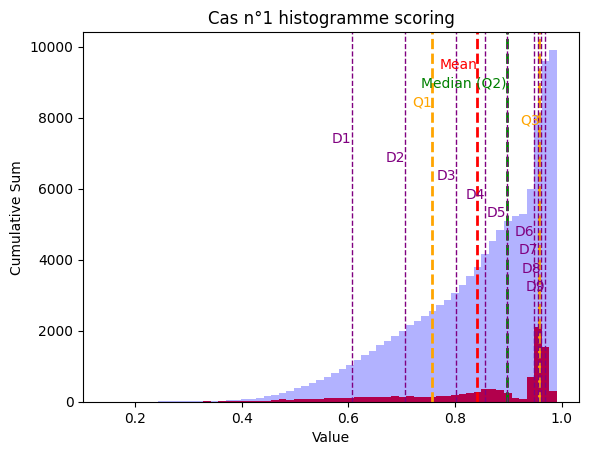

In [14]:
display_dataframe(pd.DataFrame(list(calculate_deciles(step_1_results_df["result_score"], 10).items()), columns=['Quantile', 'Valeur']))
plot_histogram(data = step_1_results_df["result_score"], bins=60, title="Cas n°1 histogramme scoring")

,Quantile,Valeur
0,Quantile 1/10,-9.210340
1,Quantile 2/10,-9.210340
2,Quantile 3/10,1.502793
3,Quantile 4/10,2.113615
4,Quantile 5/10,2.590082
5,Quantile 6/10,3.155779
6,Quantile 7/10,3.868915
7,Quantile 8/10,4.925707
8,Quantile 9/10,6.756794
9,Quantile 10/10,16.049014


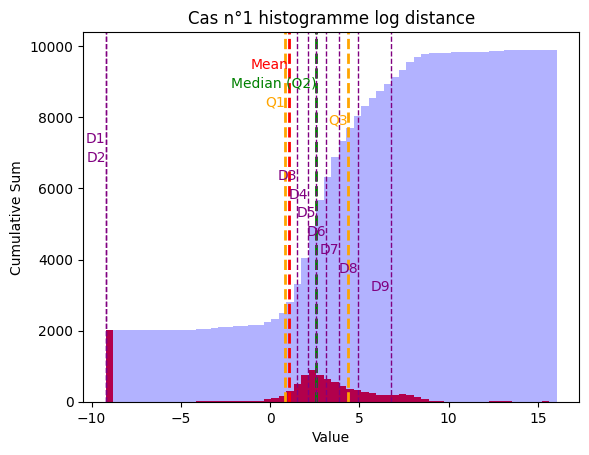

In [15]:
display_dataframe(pd.DataFrame(list(calculate_deciles(step_1_results_df["log_distance"], 10).items()), columns=['Quantile', 'Valeur']))
plot_histogram(data = step_1_results_df["log_distance"], bins=60, title="Cas n°1 histogramme log distance")

## Etape n°2

Cette étape a pour objectif de traiter des villes et codes postaux puis ensuite d'effectuer le geocoding des adresses.

In [16]:
city_postal_code_df = step_0_results_df[["identifiant_unique"]]
city_postal_code_df["ville_code_postal"] = step_0_results_df["ville"] + " " + step_0_results_df["code_postal"]

/var/folders/0q/hfx4v2917ns4l4_yd5c0ydbw0000gn/T/ipykernel_13893/1531412442.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_postal_code_df["ville_code_postal"] = step_0_results_df["ville"] + " " + step_0_results_df["code_postal"]


In [17]:
city_postal_code_df.to_csv("city_postal_code_inputs.csv")
request_api_adresse(input_file='city_postal_code_inputs.csv', output_file='city_postal_code_results.csv', column="ville_code_postal")
city_postal_code_results_df = pd.read_csv("city_postal_code_results.csv", index_col=0)
city_postal_code_results_df = city_postal_code_results_df[(city_postal_code_results_df["result_status"] != "not-found") & (city_postal_code_results_df["result_status"] != "error")]
city_postal_code_results_df = pd.merge(
    city_postal_code_results_df,
    df[["identifiant_unique", "st_y", "st_x"]], on="identifiant_unique", how='inner')

,Quantile,Valeur
0,Quantile 1/10,0.699208
1,Quantile 2/10,0.925934
2,Quantile 3/10,0.933771
3,Quantile 4/10,0.937359
4,Quantile 5/10,0.940420
5,Quantile 6/10,0.943188
6,Quantile 7/10,0.945803
7,Quantile 8/10,0.949155
8,Quantile 9/10,0.952815
9,Quantile 10/10,0.966264


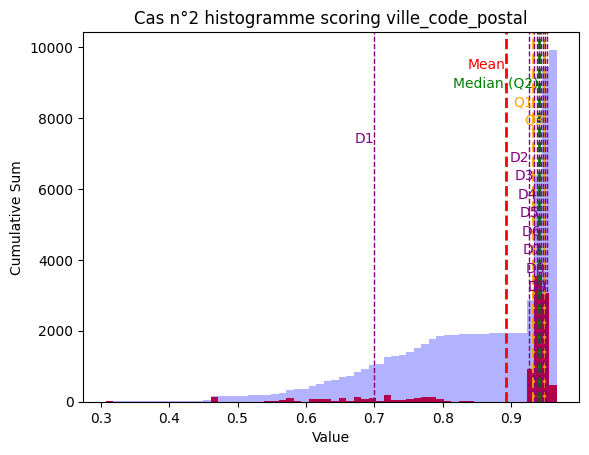

In [18]:
display_dataframe(pd.DataFrame(list(calculate_deciles(city_postal_code_results_df["result_score"], 10).items()), columns=['Quantile', 'Valeur']))
plot_histogram(data = city_postal_code_results_df["result_score"], bins=60, title="Cas n°2 histogramme scoring ville_code_postal")

In [19]:
step_2_df = pd.merge(city_postal_code_results_df[["identifiant_unique", "result_city", "result_postcode", "result_citycode"]], df[["identifiant_unique", "adresse_complement", "adresse"]], on="identifiant_unique", how='inner')
step_2_df["postcode"] = step_2_df.apply(lambda x: x["result_postcode"] if not pd.isna(x["result_postcode"]) else x["result_citycode"], axis=1).astype(pd.Int64Dtype())

step_2_df["city"] = step_2_df["result_city"].apply(lambda x: x.upper())
step_2_df = step_2_df[["identifiant_unique", "adresse_complement", "adresse", "postcode", "city"]]
step_2_df["adresse_code_postal_ville"] = step_2_df["adresse"] + " " + step_2_df["postcode"].astype(str) + " " + step_2_df["city"]
step_2_df["completed_address"] = step_2_df["adresse_complement"] + " " + step_2_df["adresse_code_postal_ville"]

In [20]:
step_2_df.to_csv("step_2_inputs.csv")

request_api_adresse(input_file='step_2_inputs.csv', output_file='step_21_results.csv', column="adresse_code_postal_ville")
request_api_adresse(input_file='step_2_inputs.csv', output_file='step_22_results.csv', column="completed_address")

step_21_results_df = pd.read_csv("step_21_results.csv", index_col=0)
step_22_results_df = pd.read_csv("step_22_results.csv", index_col=0)

step_21_results_df = step_21_results_df[(step_21_results_df["result_status"] != "not-found") & (step_21_results_df["result_status"] != "error")]
step_22_results_df = step_22_results_df[(step_22_results_df["result_status"] != "not-found") & (step_22_results_df["result_status"] != "error")]

step_21_results_df["result_postcode"] = step_21_results_df.apply(lambda x: x["result_postcode"] if not pd.isna(x["result_postcode"]) else x["result_citycode"], axis=1)
step_22_results_df["result_postcode"] = step_22_results_df.apply(lambda x: x["result_postcode"] if not pd.isna(x["result_postcode"]) else x["result_citycode"], axis=1)

step_21_results_df["postcode"].fillna(0, inplace=True)
step_22_results_df["postcode"].fillna(0, inplace=True)
step_21_results_df["result_postcode"].fillna(0, inplace=True)
step_22_results_df["result_postcode"].fillna(0, inplace=True)

step_21_results_df["postcode"] = step_21_results_df["postcode"].astype(int)
step_22_results_df["postcode"] = step_22_results_df["postcode"].astype(int)

step_21_results_df = step_21_results_df[step_21_results_df["result_postcode"].notna()]
step_21_results_df["result_postcode"] = step_21_results_df["result_postcode"].astype(int)

step_22_results_df = step_22_results_df[step_22_results_df["result_postcode"].notna()]
step_22_results_df["result_postcode"] = step_22_results_df["result_postcode"].astype(int)


step_21_results_df["result_city"] = step_21_results_df["result_city"].apply(lambda x: x.upper())
step_21_results_df["city"] = step_21_results_df["city"].apply(lambda x: x.upper())
step_22_results_df["result_city"] = step_22_results_df["result_city"].apply(lambda x: x.upper())
step_22_results_df["city"] = step_22_results_df["city"].apply(lambda x: x.upper())

step_21_results_df["origin"] = "cas_21"
step_22_results_df["origin"] = "cas_22"

In [21]:
step_21_results_df = pd.merge(
    step_21_results_df,
    df[["identifiant_unique", "st_y", "st_x"]], on="identifiant_unique", how='inner')

step_21_results_df["distance"] = step_21_results_df.apply(
     lambda x: haversine(x["st_y"], x["st_x"], x["latitude"], x["longitude"]), axis=1
)

step_21_results_df["log_distance"] = np.log(step_21_results_df["distance"]+0.0001)

In [22]:
step_22_results_df = pd.merge(
    step_22_results_df,
    df[["identifiant_unique", "st_y", "st_x"]], on="identifiant_unique", how='inner')

step_22_results_df["distance"] = step_22_results_df.apply(
     lambda x: haversine(x["st_y"], x["st_x"], x["latitude"], x["longitude"]), axis=1
)

step_22_results_df["log_distance"] = np.log(step_22_results_df["distance"]+0.0001)

In [23]:
step_21_results_df = step_21_results_df[["identifiant_unique"] + results_columns]
step_22_results_df = step_22_results_df[["identifiant_unique"] + results_columns]

In [24]:
step_2_results_df = select_best_rows(step_21_results_df, step_22_results_df)
step_2_results_df.result_postcode = step_2_results_df.result_postcode.astype(pd.Int64Dtype())

In [25]:
step_2_results_df.to_csv("step_2_results.csv")

## Etape n°3

Cette étape a pour but d'évaluer l'importance d `adresse_complement`.

In [26]:
step_3_df = step_0_results_df[step_0_results_df.adresse_complement != ""]
step_3_df["with_complement_address"] = step_3_df["adresse_complement"] + " " + step_3_df["adresse"] + " " + step_3_df["code_postal"] + " " + step_3_df["ville"]
step_3_df["without_complement_address"] = step_3_df["adresse"] + " " + step_3_df["code_postal"] + " " + step_3_df["ville"]

step_3_df = step_3_df[["identifiant_unique", "without_complement_address", "with_complement_address", "st_y", "st_x"]]

/var/folders/0q/hfx4v2917ns4l4_yd5c0ydbw0000gn/T/ipykernel_13893/2095848993.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  step_3_df["with_complement_address"] = step_3_df["adresse_complement"] + " " + step_3_df["adresse"] + " " + step_3_df["code_postal"] + " " + step_3_df["ville"]
/var/folders/0q/hfx4v2917ns4l4_yd5c0ydbw0000gn/T/ipykernel_13893/2095848993.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  step_3_df["without_complement_address"] = step_3_df["adresse"] + " " + step_3_df["code_postal"] 

In [27]:
step_3_df.to_csv("step_3_inputs.csv")

request_api_adresse(input_file='step_3_inputs.csv', output_file='step_31_results.csv', column="with_complement_address")
request_api_adresse(input_file='step_3_inputs.csv', output_file='step_32_results.csv', column="without_complement_address")
step_31_results_df = pd.read_csv("step_31_results.csv", index_col=0)
step_32_results_df = pd.read_csv("step_32_results.csv", index_col=0)


step_31_results_df = step_31_results_df[(step_31_results_df["result_status"] != "not-found") & (step_31_results_df["result_status"] != "error")]
step_32_results_df = step_32_results_df[(step_32_results_df["result_status"] != "not-found") & (step_32_results_df["result_status"] != "error")]


step_31_results_df["distance"] = step_31_results_df.apply(
     lambda x: haversine(x["st_y"], x["st_x"], x["latitude"], x["longitude"]), axis=1
)
step_32_results_df["distance"] = step_32_results_df.apply(
     lambda x: haversine(x["st_y"], x["st_x"], x["latitude"], x["longitude"]), axis=1
)

step_31_results_df["log_distance"] = np.log(step_31_results_df["distance"]+0.0001)
step_32_results_df["log_distance"] = np.log(step_32_results_df["distance"]+0.0001)

,Quantile,Valeur
0,Quantile 1/10,0.482564
1,Quantile 2/10,0.541079
2,Quantile 3/10,0.575672
3,Quantile 4/10,0.609496
4,Quantile 5/10,0.637922
5,Quantile 6/10,0.675014
6,Quantile 7/10,0.710057
7,Quantile 8/10,0.748996
8,Quantile 9/10,0.798340
9,Quantile 10/10,0.960113


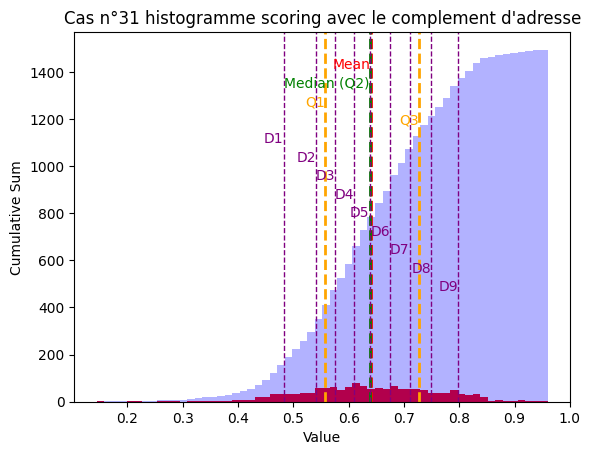

In [28]:
display_dataframe(pd.DataFrame(list(calculate_deciles(step_31_results_df["result_score"], 10).items()), columns=['Quantile', 'Valeur']))
plot_histogram(data = step_31_results_df["result_score"], bins=60, title="Cas n°31 histogramme scoring avec le complement d'adresse")

,Quantile,Valeur
0,Quantile 1/10,0.622394
1,Quantile 2/10,0.741710
2,Quantile 3/10,0.828207
3,Quantile 4/10,0.875110
4,Quantile 5/10,0.941434
5,Quantile 6/10,0.951334
6,Quantile 7/10,0.957059
7,Quantile 8/10,0.962518
8,Quantile 9/10,0.968782
9,Quantile 10/10,0.987251


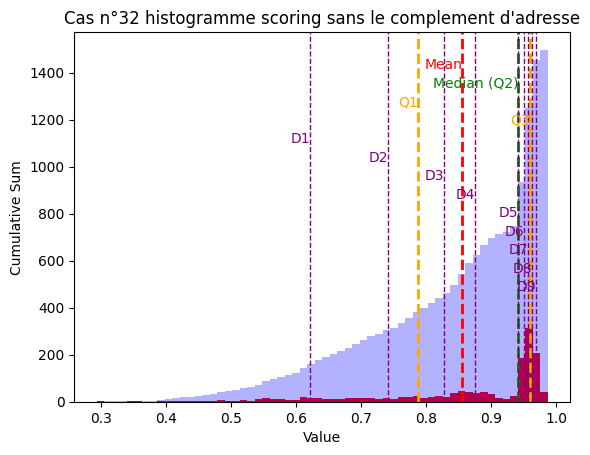

In [50]:
display_dataframe(pd.DataFrame(list(calculate_deciles(step_32_results_df["result_score"], 10).items()), columns=['Quantile', 'Valeur']))
plot_histogram(data = step_32_results_df["result_score"], bins=60, title="Cas n°32 histogramme scoring sans le complement d'adresse")

In [30]:
step_31_results_df["origin"] = "cas_31"
step_32_results_df["origin"] = "cas_32"
step_3_results_df = select_best_rows(step_31_results_df, step_32_results_df)
step_3_results_df.result_postcode = step_3_results_df.result_postcode.astype(pd.Int64Dtype())

In [31]:
step_3_results_df.to_csv("step_3_results.csv")

In [53]:
100 * step_3_results_df.origin.value_counts() / len(step_3_results_df)

origin
cas_32    94.188377
cas_31     5.811623
Name: count, dtype: float64

## Etape n°4

In [40]:
step_1_results_df = step_1_results_df[["identifiant_unique"] + results_columns]
results_df = select_best_rows(select_best_rows(step_1_results_df, step_2_results_df), step_3_results_df)

,Quantile,Valeur
0,Quantile 1/10,0.701269
1,Quantile 2/10,0.819042
2,Quantile 3/10,0.873958
3,Quantile 4/10,0.938733
4,Quantile 5/10,0.949676
5,Quantile 6/10,0.954966
6,Quantile 7/10,0.959867
7,Quantile 8/10,0.964997
8,Quantile 9/10,0.971519
9,Quantile 10/10,0.990331


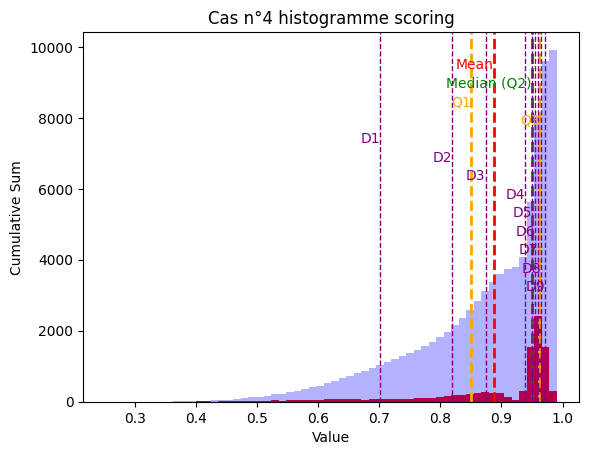

In [41]:
display_dataframe(pd.DataFrame(list(calculate_deciles(results_df["result_score"], 10).items()), columns=['Quantile', 'Valeur']))
plot_histogram(data = results_df["result_score"], bins=60, title="Cas n°4 histogramme scoring")

,Quantile,Valeur
0,Quantile 1/10,0.606143
1,Quantile 2/10,0.706559
2,Quantile 3/10,0.801166
3,Quantile 4/10,0.856111
4,Quantile 5/10,0.896488
5,Quantile 6/10,0.947861
6,Quantile 7/10,0.955082
7,Quantile 8/10,0.961249
8,Quantile 9/10,0.968543
9,Quantile 10/10,0.990331


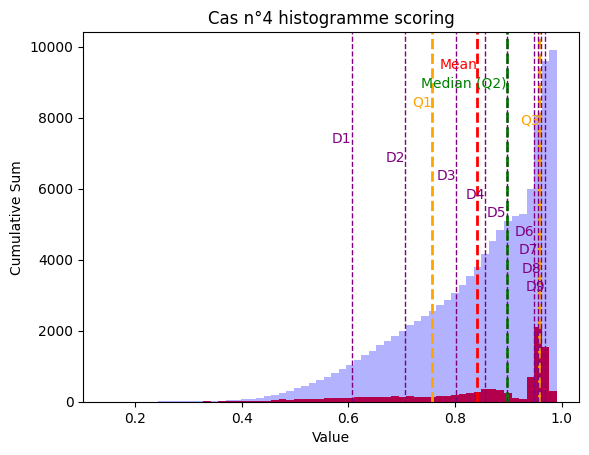

In [42]:
display_dataframe(pd.DataFrame(list(calculate_deciles(step_1_results_df["result_score"], 10).items()), columns=['Quantile', 'Valeur']))
plot_histogram(data = step_1_results_df["result_score"], bins=60, title="Cas n°4 histogramme scoring")

In [43]:
results_df.result_postcode = results_df.result_postcode.astype(pd.Int64Dtype())

In [44]:
results_df.to_csv("results_df.csv")

In [48]:
results_df.origin.value_counts()

origin
cas_1     7495
cas_21    2154
cas_32     257
cas_22      14
Name: count, dtype: int64

In [49]:
100 * results_df.origin.value_counts() / len(results_df)

origin
cas_1     75.554435
cas_21    21.713710
cas_32     2.590726
cas_22     0.141129
Name: count, dtype: float64

## Conclusion

Cette analyse a permis de mettre en lumière plusieurs points clés :

1. **Amélioration des Performances** : En utilisant le seuil des 20% des pires valeurs de `result_score` comme indicateur, une amélioration significative des performances est observable. Les étapes 2 et 3 ont permis un gain de 11% par rapport à l'étape 1, démontrant l'efficacité des méthodes de nettoyage et de normalisation des adresses appliquées.

2. **Efficacité des Étapes 2 et 3** : Plus de 24% des adresses ont affiché des scores améliorés dans ces étapes, soulignant l'importance de ces procédures dans l'amélioration de la qualité des données.

3. **Impact du Complément d'Adresse** : Nous constatons que sur 94% des adresses ayant un complément, ce dernier rend la détection plus difficile. Cette observation suggère la nécessité d'une attention particulière au traitement des compléments d'adresse pour optimiser la précision.

4. **Fiabilité de BAN et OpenStreetMap** : Il est important de noter que les données de coordonnées utilisées dans cette analyse proviennent de la Base Adresse Nationale (BAN), qui elle-même s'appuie sur les données d'OpenStreetMap. Cette source est reconnue pour sa précision et sa fiabilité, offrant une base solide pour nos opérations de géocodage.


### Pistes pour le Futur :

- **Évaluation Basée sur la Distance** : Un indicateur basé sur la distance pourrait être envisagé pour évaluer davantage la véracité des données. Cependant, en l'absence d'informations précises sur l'origine des coordonnées `st_x` et `st_y`, il était difficile d'intégrer cette dimension dans l'analyse actuelle.

- **Utilisation du SIRET** : Une grande partie des adresses analysées correspond d'après les `identifiant_unique` à des établissements d'unités légales. Il pourrait être judicieux de modifier le formulaire d'inscription pour inclure le numéro de SIRET et ainsi récupérer l'adresse directement depuis la base de données SIREN. Cela pourrait améliorer l'exactitude des adresses recueillies et simplifier le processus de vérification, de plus cela ferait un formulaire plus simple pour les utilisateurs.

- **Diversification des Outils de Géocodage** : Bien que les données de BAN soient fiables, il pourrait être bénéfique d'explorer d'autres services (**OSRM**, **Google Maps** de géocodage pour comparer et potentiellement améliorer la précision de nos résultats.

Ces observations et recommandations pourraient guider les efforts futurs pour améliorer davantage la qualité et la fiabilité des données d'adresse.
